In [1]:
import msprime, tskit
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt
from algorithm import *

In [2]:
ts2 = msprime.sim_ancestry(3, population_size=100, sequence_length=1e5, recombination_rate=1e-8,
                         record_full_arg=True)

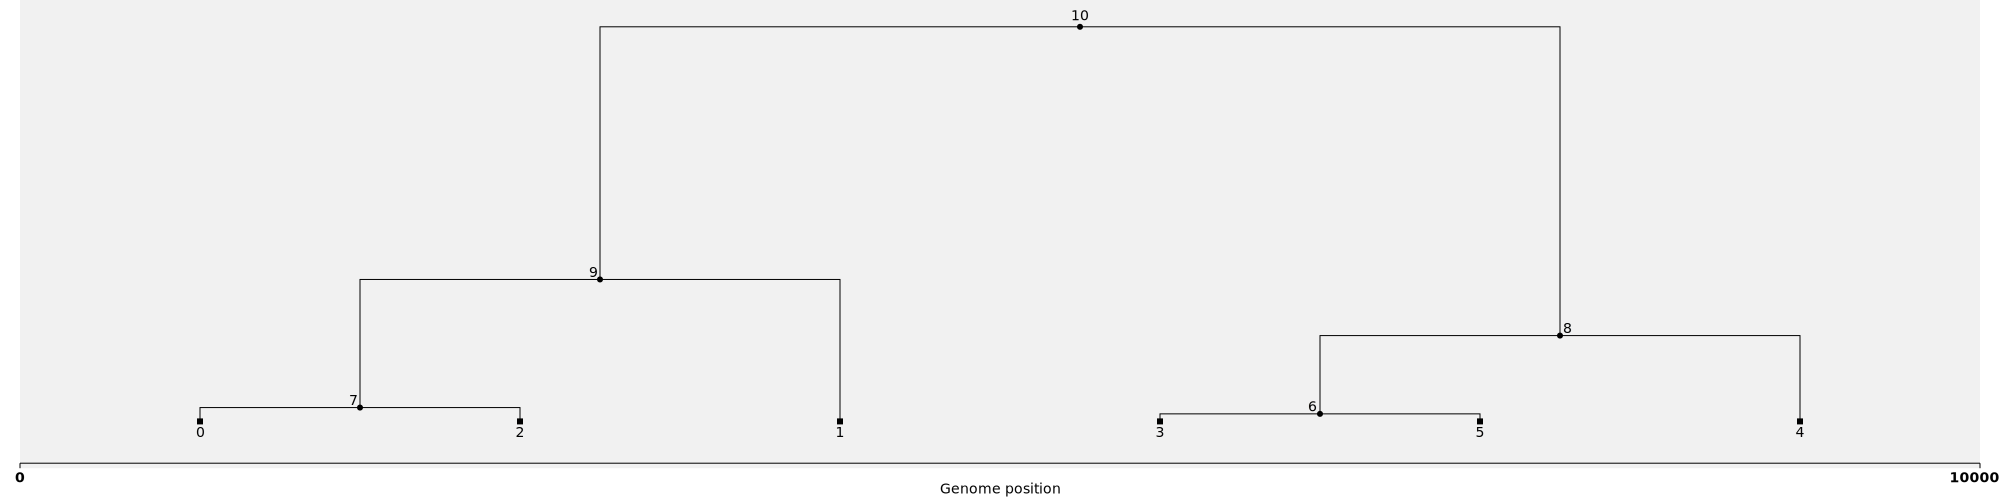

In [3]:
SVG(ts2.draw_svg(size=(2000, 500), x_lim=[0, 1e5]))

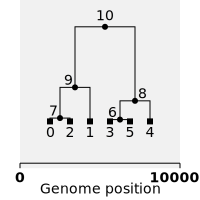

In [4]:
sts = ts2.simplify()
SVG(sts.draw_svg(x_lim=[0, 1e5]))

[10]


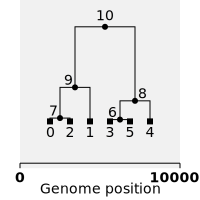

In [5]:
ts1, n = extend_edges(sts)
print(n)
SVG(ts1.draw_svg(x_lim=[0, 1e5]))

Our goal is to construct a function to measure the number of discrepancies between our inferred tree sequence $TS_1$ and the ground truth $TS_2$. For tree sequences $TS_1$ and $TS_2$ both of sequence length $L$, each have nodes at position $i$ in the genome, $x$ and $y$ respectively. From these nodes we count the number of samples which stem from them. We define these sets as $D_1(i,x)$ and $D_2(i,y)$. We count the number of descrepancies between the nodes $x$ and $y$ as their set difference, $|D_1(i,x)\vartriangle D_2(i,y)|$. We define the $\textbf{discrepancy number}$ between nodes $x$ and $y$ as 
$$ d(x,y) = \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|. $$
Using this we generalize to find the number of discrepancies between a node $x$ and the ground truth $TS_2$,
$$ d(x,TS_2) = \inf_{y\in TS_2.nodes()} d(x,y).$$
Finally, to compute the number of discrepancies between tree sequences we use the function
$$d(TS_1,TS_2) = \sum_{x\in TS_1.nodes()} d(x,TS_2)=\sum_{x\in TS_1.nodes()} \inf_{y\in TS_2.nodes()} d(x,y) = \sum_{x\in TS_1.nodes()} \inf_{y\in TS_2.nodes()} \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|,$$
and call this the $\textbf{discrepancy number}$ between $TS_1$ and $TS_2$.

In [38]:
''' I believe here we do have to specify which tree sequence each node comes from. I could not find a function to do so
so instead I just added each nodes repecitive tree sequence as an argument. '''

def orig_node_discrepancy(x,ts1,y,ts2): # function to return the discrepancy number between two nodes, d(x,y)
    dis = 0
    for i in range(int(ts1.sequence_length)):
        tree1 = ts1.at(i)
        tree2 = ts2.at(i)
        Dx = {}
        Dy = {}
        
        for s1, s2 in zip(tree1.samples(x), tree2.samples(y)):
            Dx.add(s1)
            Dy.add(s2)
        dxy = Dx.symmetric_difference(Dy)
        dis += len(dxy)
    return dis

def node_discrepancy(x, ts1, y, ts2):
    # PLR: here's my rewrite of the above
    dis = 0
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        Dx = set(t1.samples(x))
        for z in t2.samples(y):
            if z not in Dx:
                dis += s
    return dis

def orig_node_tree_discrepancy(x, ts1, ts2): # function to return the discrepancy number between a node and tree sequence d(x,TS2)
    dmin = 0
    dis = []
    for y in range(ts2.num_nodes):
        dis.append(node_discrepancy(x,ts1,y,ts2))
    d = np.array(dis)
    dmin = np.amin(d)

    return dmin

def node_tree_discrepancy(x, ts1, ts2): # I tried to make the function faster, I am not sure if it does though

    dis = ts2.sequence_length # I need some large number here
    for y in range(ts2.num_nodes):
        xydis = node_discrepancy(x,ts1,y,ts2)
        if xydis < dis:
            dis = xydis
    
    return dis # Perhaps we could also have this function also return a list of the nodes which give us the minimal discrepancy number

In [39]:
def orig_discrepancy(ts1, ts2):
    # PLR: I don't think we need the same number of trees?
    # assert ts1.num_trees == ts2.num_trees, "Must have same number of trees between tree sequences."
    dis = 0

    for n in range(ts1.num_nodes):
        dis += orig_node_tree_discrepancy(n,ts1,ts2) 
    
    return dis

def discrepancy(ts1, ts2):
    dis = 0
    
    for n in range(ts1.num_nodes):
        dis += node_tree_discrepancy(n,ts1,ts2)
    return dis

The below errors because `Tree.samples( )` wants a node *id*, not a Node object. So, you want `test_tree1.samples(7)`.

In [10]:
test_node1 = ts1.node(7)
test_node2 = ts2.node(8)
test_tree1 = ts1.at(1000)
test_tree2 = ts2.at(1000)
list(test_tree1.samples(test_node1.id))

[0, 2]

In [14]:
testset = {s for s in test_tree1.samples(test_node1.id)}
print(testset)

{0, 2}


In [40]:
discrepancy(ts1, ts2)

0

Now we should run an experiment to see with our new metric the varying distribution of the disscrepancy number between the simulated tree sequence and its edge extended version.

In [44]:
for num_samples in [3, 5,7,9]:
    for L in [1e4, 1e5, 1e6,1e7]:
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        
        ext_sts, _ = extend_edges(sts)
        #dd = orig_discrepancy(ext_sts, ts)
        d = discrepancy(ext_sts, ts)
        print(f'number of samples = {num_samples}, length = {L}\n original discrepancy number = {d}')

number of samples = 3, length = 10000.0
 original discrepancy number = 0
number of samples = 3, length = 100000.0
 original discrepancy number = 0
number of samples = 3, length = 1000000.0
 original discrepancy number = 6561.0


KeyboardInterrupt: 